## 1.환경준비

### (1) 라이브러리 불러오기

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings 
warnings.filterwarnings('ignore')

from hanspell import spell_checker

### (2) 데이터 로딩
* 주어진 데이터셋
    * 학습 데이터 : 일상대화.xls
    * 학습 데이터 : 챗봇 데이터.xls


In [24]:
# 일상대화
common_df = pd.read_excel('/Users/hyeontae/Desktop/AIVLE-School-FAQ-ChatBot/일상대화.xlsx')

# 에이블스쿨 질문답변
faq_df = pd.read_excel('/Users/hyeontae/Desktop/AIVLE-School-FAQ-ChatBot/챗봇데이터.xlsx')

* 데이터 확인

In [25]:
# 일상대화
common_df.head()

,intent,질문,답변
0,1,떨어뜨려서 핸드폰 액정 나갔어,as 맡기세요.
1,1,액정 나갔어,as 맡기세요.
2,1,핸드폰 떨어뜨려서 고장 났나봐,as 맡기세요.
3,1,노트북이 작동이 안되네,AS센터에 맡겨보세요.
4,1,노트북 키보드가 안먹히네,AS센터에 맡겨보세요.


In [26]:
# 에이블스쿨 질문답변
faq_df.head()

,intent,Q,A
0,0,어떤 조건을 만족하면 지원할 수 있는지 알고 싶어요.,KT 에이블스쿨은 정규 4년제 대학 졸업자 및 졸업예정자 중 만 34세 이하 미취업...
1,0,지원자격이 어떻게 되나요?,KT 에이블스쿨은 정규 4년제 대학 졸업자 및 졸업예정자 중 만 34세 이하 미취업...
2,0,지원 조건이 궁금해요.,KT 에이블스쿨은 정규 4년제 대학 졸업자 및 졸업예정자 중 만 34세 이하 미취업...
3,0,지원 자격에 대해서 알려주세요.,KT 에이블스쿨은 정규 4년제 대학 졸업자 및 졸업예정자 중 만 34세 이하 미취업...
4,0,지원 자격 기준이 있나요?,KT 에이블스쿨은 정규 4년제 대학 졸업자 및 졸업예정자 중 만 34세 이하 미취업...


## 2.데이터 전처리

### (1) 기본 전처리


#### 1) column명 통일

In [27]:
# common_df의 컬럼명 변경.
# '질문'을 'Q'로, '답변'을 'A'로 변경
common_df.rename(columns={'질문' : 'Q', '답변' : 'A'}, inplace = True)

#### 2) 데이터셋 통합
* intent 다시 번호 재부여
* 일상대화 후에 에이블스쿨 질문답변이 오도록 처리

In [28]:
max_intent = common_df['intent'].max()
faq_df['intent'] = faq_df.intent.apply(lambda x : max_intent + x + 1)

* 데이터셋 통합

In [29]:
data = pd.concat([common_df, faq_df])
# index 재설정
data = data.reset_index(drop = True)

#### 3) 일상대화와 Q&A대화 구분 칼럼(대화유형) 만들기
* 주어진 데이터셋은 두가지 종류
* 통합 데이터에 type 칼럼을 추가하고, 일상대화를 0, Q&A를 1로 지정

In [30]:
data['type'] = data.intent.apply(lambda x : 1 if x > max_intent else 0)

In [31]:
# 결과 확인
data

,intent,Q,A,type
0,1,떨어뜨려서 핸드폰 액정 나갔어,as 맡기세요.,0
1,1,액정 나갔어,as 맡기세요.,0
2,1,핸드폰 떨어뜨려서 고장 났나봐,as 맡기세요.,0
3,1,노트북이 작동이 안되네,AS센터에 맡겨보세요.,0
4,1,노트북 키보드가 안먹히네,AS센터에 맡겨보세요.,0
...,...,...,...,...
1293,53,KT 에이블스쿨만의 장점이 무엇인지 상세히 설명해주세요,KT 에이블스쿨에서는 이론/실습 교육에 나아가 기업 실전형 프로젝트를 중심으로 실무...,1
1294,53,다른 교육과의 차이점은 무엇인가요?,KT 에이블스쿨에서는 이론/실습 교육에 나아가 기업 실전형 프로젝트를 중심으로 실무...,1
1295,53,다른 교육과 차이점이 있나요?,KT 에이블스쿨에서는 이론/실습 교육에 나아가 기업 실전형 프로젝트를 중심으로 실무...,1
1296,53,다른 국비 지원 교육보다 특별한 점이 있는지 궁금해요,KT 에이블스쿨에서는 이론/실습 교육에 나아가 기업 실전형 프로젝트를 중심으로 실무...,1


### (2) 데이터 탐색


#### 1) intent별 질문 개수 파악

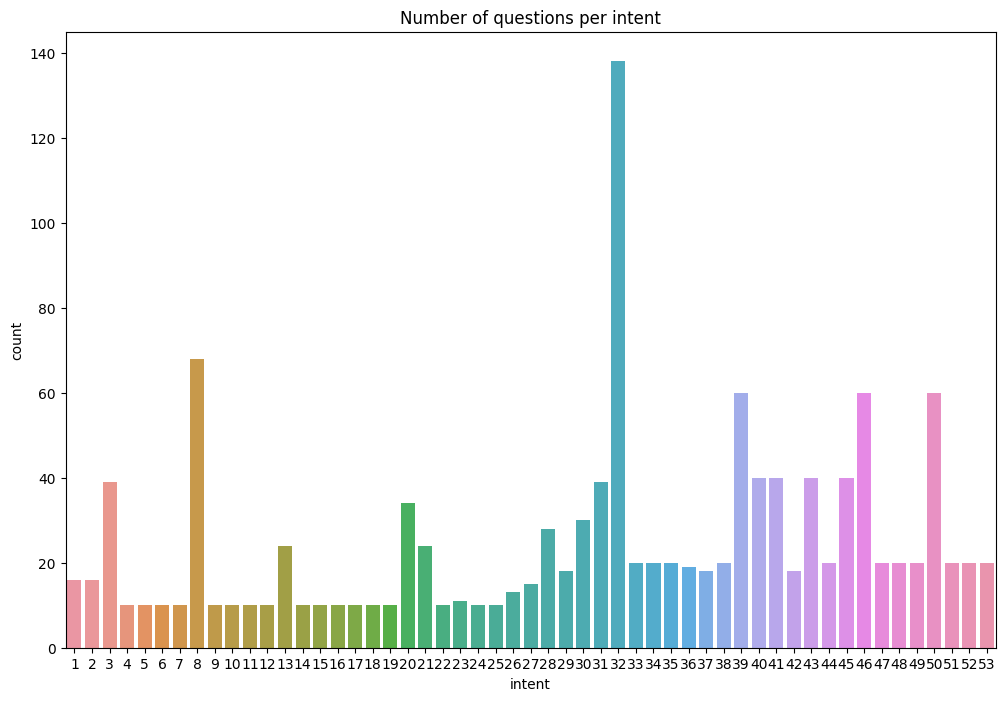

In [32]:
plt.figure(figsize = (12, 8))
sns.countplot(x = 'intent', data = data)
plt.title('Number of questions per intent')
plt.show()

#### 2) 질문별 문장 길이 분포

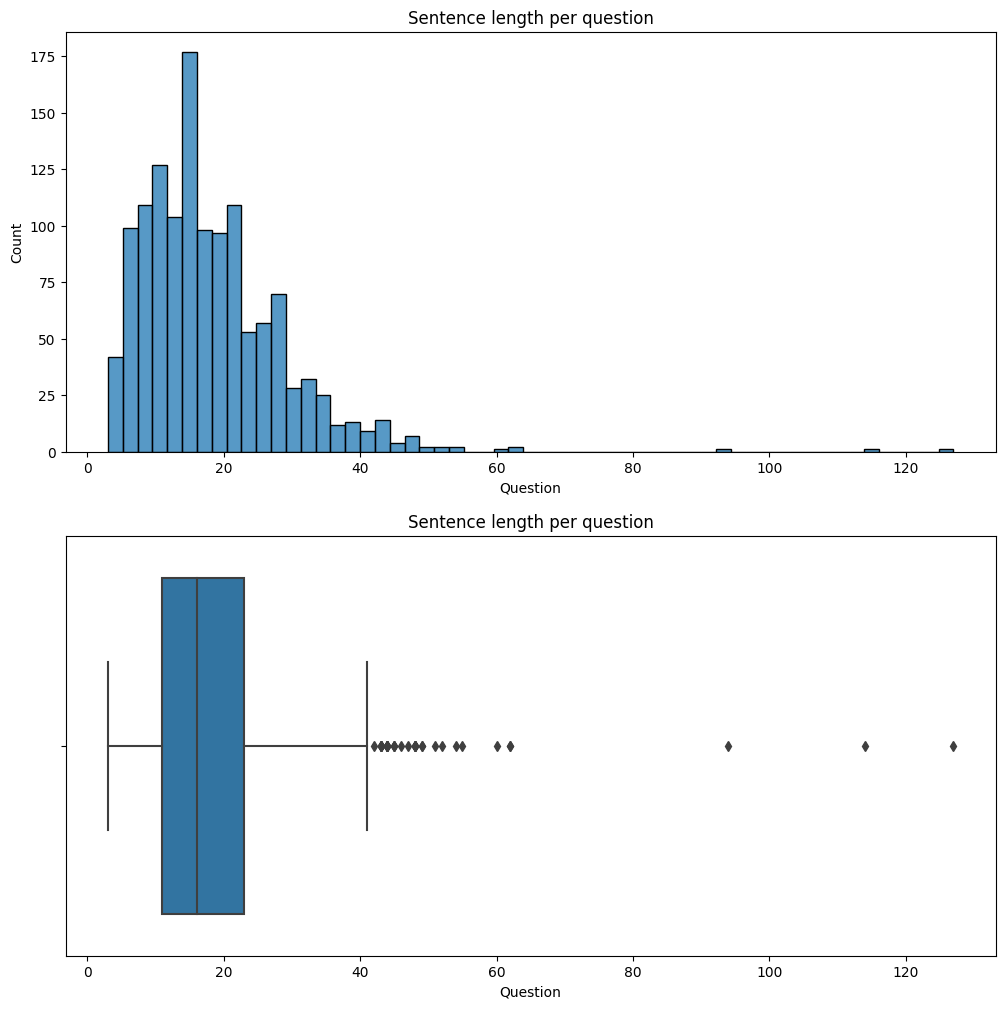

In [33]:
# 질문 별 문장 길이 확인
sentence_length = data.Q.apply(lambda x : len(x))
plt.figure(figsize = (12, 12))
# histplot
plt.subplot(2,1,1)
sns.histplot(sentence_length)
plt.xlabel('Question')
plt.title('Sentence length per question')
# boxplot
plt.subplot(2,1,2)
sns.boxplot(x = sentence_length)
plt.xlabel('Question')
plt.title('Sentence length per question')
plt.show()

#### 3) 대화 유형(type) 별 문장 길이 분포 비교


##### Type 0


In [34]:
# Type 0 기초통계량 확인
type0_sentence_length = data.loc[data['type'] == 0].Q.apply(lambda x : len(x))
type0_sentence_length.describe()

count    506.000000
mean      10.126482
std        3.971658
min        3.000000
25%        7.000000
50%       10.000000
75%       12.000000
max       28.000000
Name: Q, dtype: float64

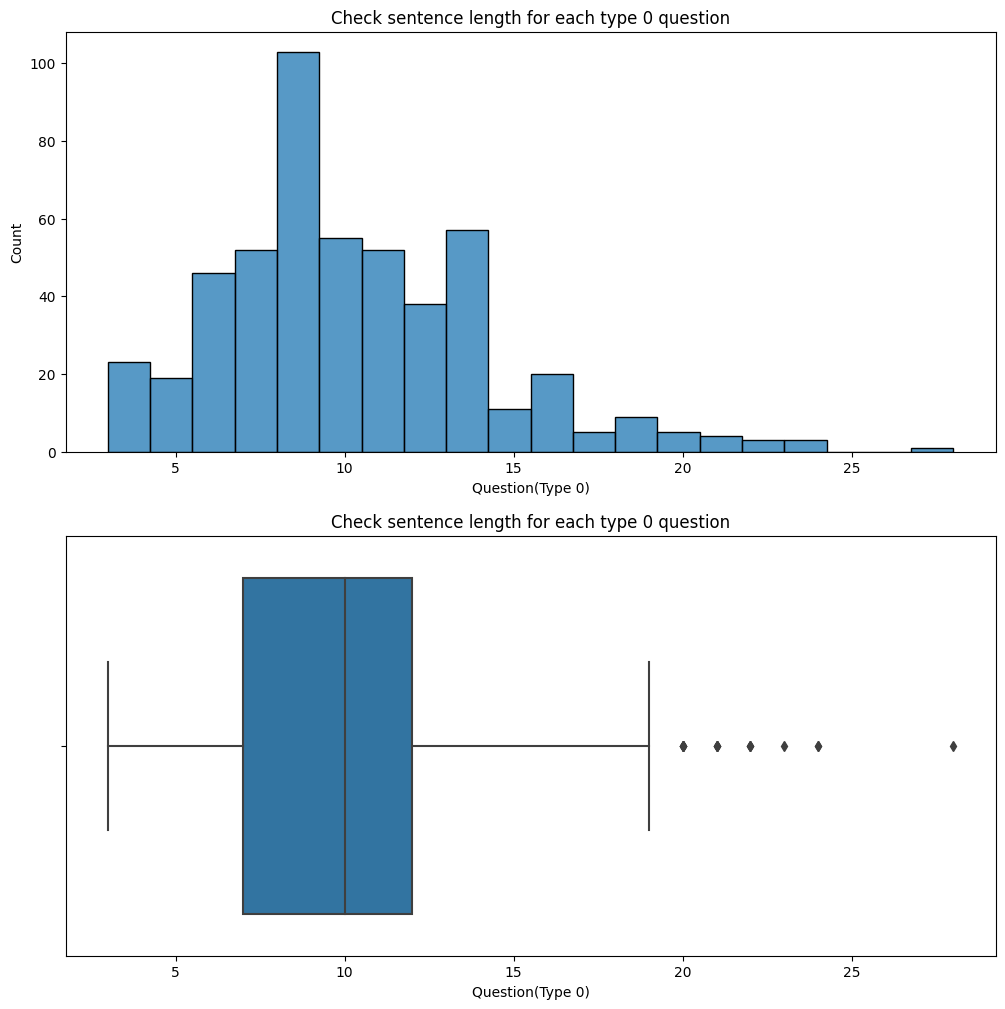

In [35]:
# Type 0의 질문 별 문장 길이 확인
plt.figure(figsize = (12, 12))
# histplot
plt.subplot(2,1,1)
sns.histplot(type0_sentence_length)
plt.xlabel('Question(Type 0)')
plt.title('Check sentence length for each type 0 question')
# boxplot
plt.subplot(2,1,2)
sns.boxplot(x = type0_sentence_length)
plt.xlabel('Question(Type 0)')
plt.title('Check sentence length for each type 0 question')
plt.show()

##### Type 1


In [36]:
# Type 1 기초통계량 확인
type1_sentence_length = data.loc[data['type'] == 1].Q.apply(lambda x : len(x))
type1_sentence_length.describe()

count    792.000000
mean      23.434343
std       10.258270
min        6.000000
25%       17.000000
50%       21.000000
75%       28.000000
max      127.000000
Name: Q, dtype: float64

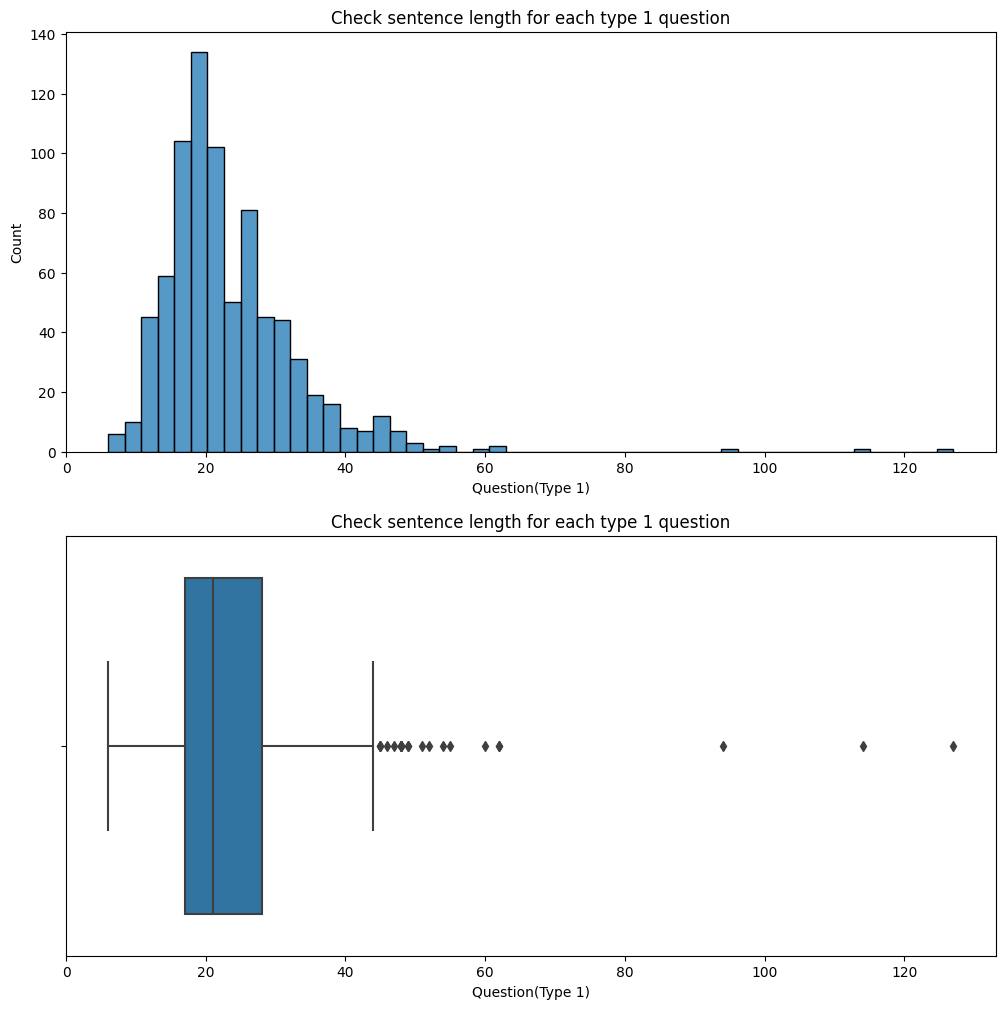

In [37]:
# Type 1의 질문 별 문장 길이 확인
plt.figure(figsize = (12, 12))
# histplot
plt.subplot(2,1,1)
sns.histplot(type1_sentence_length)
plt.xlabel('Question(Type 1)')
plt.title('Check sentence length for each type 1 question')
# boxplot
plt.subplot(2,1,2)
sns.boxplot(x = type1_sentence_length)
plt.xlabel('Question(Type 1)')
plt.title('Check sentence length for each type 1 question')
plt.show()

### (3) 특수문자 제거

In [38]:
data['Q'] = data['Q'].str.replace(pat = r'[^가-힣\s]',repl=r'',regex = True)
data['Q'] = data['Q'].str.replace(r'\n','',regex = True)

### (4) 맞춤법 수정

#### 1) 맞춤법 수정 함수 설정

In [39]:
def return_spell_checker(text) :
    spelled_sent = spell_checker.check(text)
    checked_sent = spelled_sent.checked
    return checked_sent

#### 2) 맞춤법 수정

In [40]:
data['Q'] = data.Q.apply(lambda x : return_spell_checker(x))

### (5) 형태소 분석

#### 1) 형태소 분석을 위한 함수 정의

In [41]:
# 형태소 분석 수행 함수
def tokenize(original_sent, nouns=False):
    from konlpy.tag import Okt

    tokenizer = Okt()
    sentence = original_sent.replace('\n', '').strip()
    tokens = tokenizer.morphs(sentence)
    tokenized_sent = ' '.join(tokens)
    return tokenized_sent

#### 2) 형태소 분석 후 저장

* Okt 사용

In [42]:
data['Q'] = data.Q.apply(lambda x : tokenize(x))

### (6) 데이터 파일로 저장

In [43]:
joblib.dump(data, '/Users/hyeontae/Desktop/AIVLE-School-FAQ-ChatBot/dataset.pkl')

['/Users/hyeontae/Desktop/AIVLE-School-FAQ-ChatBot/dataset.pkl']